In [1]:
import os
import pickle
import numpy as np
from mne import viz
from scipy import io
from matplotlib import colors, pyplot as plt
from sklearn import model_selection, ensemble, svm, discriminant_analysis, neighbors, linear_model

In [2]:
CAF_DOSE = 200
SIGNIFICANT_P = 0.05

CLASSIFIER = 'SVM' # SVM, LDA, QDA, GradientBoosting, KNeighbors, SGD-LOG, SGD-PERC

FEATURE_PATH = 'C:\\Users\\Philipp\\Documents\\Caffeine\\Features{dose}\\Combined'.format(dose=CAF_DOSE)
PROJECT_PATH = 'E:\\Cafeine_data'

STAGES = ['AWA', 'AWSL', 'NREM', 'REM']
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma']

In [3]:
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
with open(os.path.join(FEATURE_PATH, 'data_avg.pickle'), 'rb') as file:
    data = pickle.load(file)
with open(os.path.join(FEATURE_PATH, 'labels_avg.pickle'), 'rb') as file:
    labels = pickle.load(file)
with open(os.path.join(FEATURE_PATH, 'groups_avg.pickle'), 'rb') as file:
    groups = pickle.load(file)

In [5]:
scores = {}
for stage in STAGES:
    scores[stage] = {}
    print(f'Sleep stage {stage}')
    for feature in data[stage].keys():
        scores[stage][feature] = []
        for electrode in range(20):
            print(f'   Training {CLASSIFIER} for feature {feature} (electrode {electrode + 1:2})...', end='\r')
            if CLASSIFIER.lower() == 'svm':
                clf = svm.SVC(gamma='scale')
            elif CLASSIFIER.lower() == 'lda':
                clf = discriminant_analysis.LinearDiscriminantAnalysis()
            elif CLASSIFIER.lower() == 'qda':
                clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
            elif CLASSIFIER.lower() == 'gradientboosting':
                clf = ensemble.GradientBoostingClassifier(n_estimators=25)
            elif CLASSIFIER.lower() == 'kneighbors':
                clf = neighbors.KNeighborsClassifier()
            elif CLASSIFIER.lower() == 'sgd-log':
                clf = linear_model.SGDClassifier(loss='log', max_iter=1000, tol=1e-3)
            elif CLASSIFIER.lower() == 'sgd-perc':
                clf = linear_model.SGDClassifier(loss='perceptron', max_iter=1000, tol=1e-3)
            
            x = data[stage][feature][:,electrode].reshape((-1, 1))
            y = labels[stage]
            
            current = model_selection.permutation_test_score(estimator=clf,
                                                             X=x,
                                                             y=y,
                                                             groups=groups[stage],
                                                             cv=10,
                                                             n_permutations=1000,
                                                             n_jobs=5)
            scores[stage][feature].append(current)
        print()

Sleep stage AWA
   Training SGD-PERC for feature PSD_delta (electrode 20)...
   Training SGD-PERC for feature PSD_theta (electrode 20)...
   Training SGD-PERC for feature PSD_alpha (electrode 20)...
   Training SGD-PERC for feature PSD_sigma (electrode 20)...
   Training SGD-PERC for feature PSD_beta (electrode 20)...
   Training SGD-PERC for feature PSD_low gamma (electrode 20)...
   Training SGD-PERC for feature SpecShanEn (electrode 20)...
   Training SGD-PERC for feature SpecPermEn (electrode 20)...
   Training SGD-PERC for feature SpecSampEn (electrode 20)...
   Training SGD-PERC for feature SampEn (electrode 20)...
Sleep stage NREM
   Training SGD-PERC for feature PSD_delta (electrode 20)...
   Training SGD-PERC for feature PSD_theta (electrode 20)...
   Training SGD-PERC for feature PSD_alpha (electrode 20)...
   Training SGD-PERC for feature PSD_sigma (electrode 20)...
   Training SGD-PERC for feature PSD_beta (electrode 20)...
   Training SGD-PERC for feature PSD_low gamma (el

C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   Training SGD-PERC for feature PSD_beta (electrode 20)...
   Training SGD-PERC for feature PSD_low gamma (electrode 20)...
   Training SGD-PERC for feature SpecShanEn (electrode 20)...
   Training SGD-PERC for feature SpecPermEn (electrode 20)...
   Training SGD-PERC for feature SpecSampEn (electrode 20)...
   Training SGD-PERC for feature SampEn (electrode 20)...


In [6]:
with open(os.path.join('..', f'scores{CAF_DOSE}', f'scores_{CLASSIFIER}.pickle'), 'wb') as file:
    pickle.dump(scores, file)

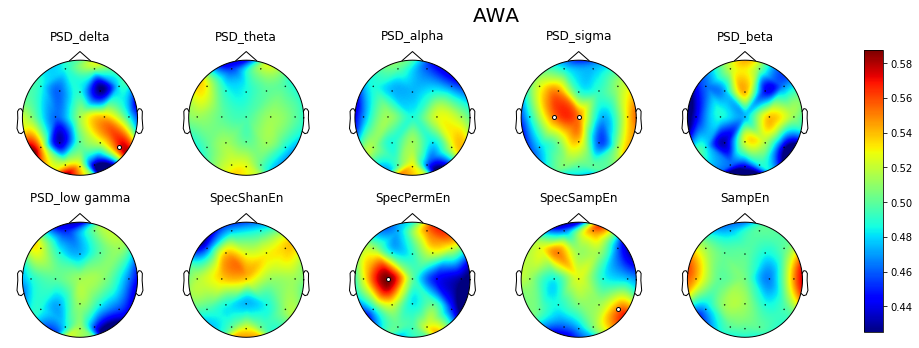

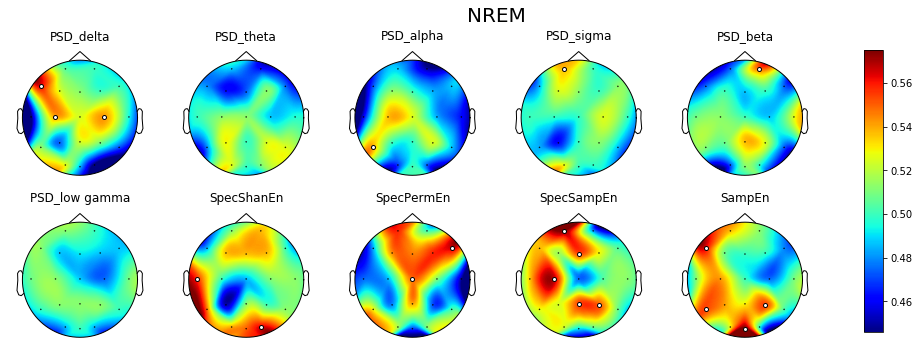

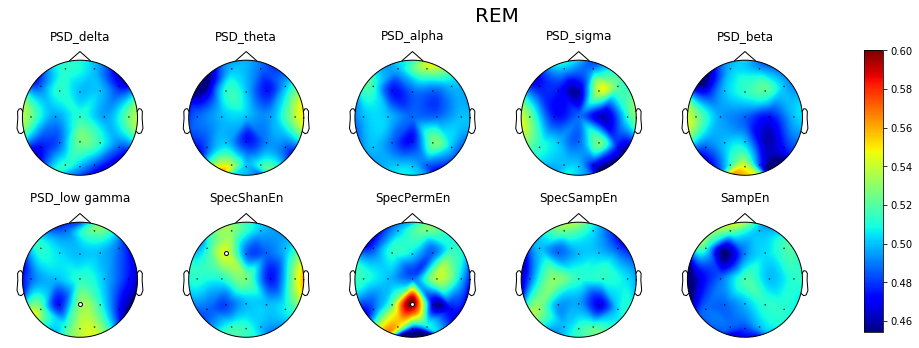

In [7]:
plot_rows = 2
plot_cols = 5
colormap = 'inferno'

for stage in STAGES:
    plt.figure(figsize=(18, 5))
    plt.suptitle(stage, y=1.05, fontsize=20)
    
    all_scores = [[elec[0] for elec in ft] for ft in scores[stage].values()]
    vmin = np.min(all_scores)
    vmax = np.max(all_scores)
    
    subplot_index = 1
    axes = []
    for feature in scores[stage].keys():
        curr_acc = np.array([score[0] for score in scores[stage][feature]])
        curr_sig = np.array([score[2] for score in scores[stage][feature]])
        
        ax = plt.subplot(plot_rows, plot_cols, subplot_index)
        axes.append(ax)
        plt.title(feature)
        mask = curr_sig < SIGNIFICANT_P
        viz.plot_topomap(curr_acc, sensor_pos, mask=mask, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
        subplot_index += 1
    
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
    plt.savefig(f'..\\figures{CAF_DOSE}\\{CLASSIFIER}_DA_{stage}.png')
    plt.show()